# PCA主元分析   
假设数据符合高斯分布，目标是得到一组正交基，使得数据在这组正交基上分布放方差最大，PCA最大的用途是数据降维。   
已知一组数据$(X_1, X_2, ..., X_N)$,其中每个数据$X_i$都是n维列向量，利用矩阵分解求解PCA的步骤如下
1. 计算均值   
   $X_{mean} = \frac{1}{N}\sum_{i=1}^N X_i$
2. 去中心化   
   $\bar X_i = X_i - X_{mean}$
3. 计算协方差矩阵 (特征的协方差）    
   $C = \bar X \bar X^T$
4. 矩阵分解，求$C$的特征值和特征向量  
   $(\lambda _i，V_i) \ \ \ i = 1,2,...,N$   
   其中$\lambda _i$是特征值，$V_i$是特征向量，其中$V_i$就是要求取的正交基，$\lambda _i$表示数据在$V_i$的分布，和数据在该方向上投影
   的方差正相关
   

## 特征值和特征向量
向量X的特征值和特征向量的定义如下    
$\lambda X = V^TX$   
这个公式说明$X$乘以一个标量$\lambda$的结果和乘以另一个向量$V$一样，其中$\lambda$和$V$就是特征值和特征向量。 上式等号左右两侧同时右乘$X^T$得到    
$\lambda X X^T = V^TXX^T$   
如果$X$均值为零，令$C=\bar X \bar X^T$表示协方差矩阵，则上式得到
$\lambda C = V^T C$    
即$\lambda$和$V^T$也是$C$的特征值和特征向量

In [1]:
import cv2
import sys,os
import numpy as np


sample_size = (64//2,64//2)
smallset_size = 10 #每类下采样，方便调试

flag_debug = True

In [2]:
def load_mnist(num_per_class, dataset_root="C:/dataset/mnist/",resize=sample_size):
    data_pairs = []
    labeldict = {}
    ds_root = os.path.join(dataset_root,'train')
    for rdir, pdirs, names in os.walk(ds_root):
        for name in names:
            basename,ext = os.path.splitext(name)
            if ext != ".jpg":
                continue
            fullpath = os.path.join(rdir,name)
            label = fullpath.split('\\')[-2]
            label = int(label)
            if num_per_class > 0 and ( label in labeldict.keys() ) and labeldict[label] >= num_per_class:
                continue
            data_pairs.append((label,fullpath))
            if label in labeldict:
                labeldict[label] += 1
            else:
                labeldict[label] = 1
    data = np.zeros((resize[0]*resize[1],len(data_pairs)))
    labels = np.zeros(len(data_pairs))
    for col,(label, path) in enumerate(data_pairs):
        img = cv2.imread(path,0)
        img = cv2.resize(img,resize)
        img = (img / 255.0).flatten()
        data[:,col] = img
        labels[col] = label
    return (data,labels)


    

In [3]:
X,Y = load_mnist(smallset_size)
print('data shape: {}'.format(X.shape))
Xmean = np.reshape( X.mean(axis=1),(-1,1))
Xmean = np.tile(Xmean,(1,X.shape[1]))
print('mean shape: {}'.format(Xmean.shape))
Xbar = X - Xmean
C = Xbar.dot(Xbar.transpose())
print("conv shape: {}".format(C.shape))

data shape: (1024, 100)
mean shape: (1024, 100)
conv shape: (1024, 1024)


计算矩阵$C$的特征值和特征向量有两个方法   
1. 直接计算特征值，特征向量
2. 利用SVD
在数据降维中，需要按照方差（特征值）选择若干维度，抛弃其他维度，达到降维目的。

In [4]:
import pdb
def get_top_idx(lam, ratio):
    #pdb.set_trace()
    for k in range(1,len(lam)):
        if np.sum(lam[:k]) > ratio * np.sum(lam):
            #print('{} {}'.format(lam[:k].sum(), lam.sum()))
            return k
    return len(lam)


def calc_inv_basic(C,ratio=-1,N=-1):
    print(C.shape)
    if ratio < 0 and N < 0:
        return C.shape[1]
    U,V = np.linalg.eigh(C)
    U = U[::-1]
    for k in range(C.shape[1]):
        V[k,:] = V[k,:][::-1] 
    if ratio > 0:
        idx = get_top_idx(U,ratio)
    else:
        idx = N
    topV = V[:,:idx]
    return topV


def calc_inv_svd(C, ratio=-1,N=-1):
    if ratio < 0 and N < 0:
        return C.shape[1]
    U,D,V = np.linalg.svd(C)
    if ratio > 0:
        idx = get_top_idx(D,ratio)
    else:
        idx = N
    topU = U[:,:idx]
    return topU

不同方法得到的特征向量的方向可能不同，需要取模后再比较

In [8]:
#mat = [[-1,-1,0,2,1],[2,0,0,-1,-1],[2,0,1,1,0]]
#C = np.asarray(mat) 
#C = C.transpose().dot(C)
ratio = 0.9
N = -1
topV_from_origin = calc_inv_basic(C,N=N, ratio=ratio)
topV_from_svd = calc_inv_svd(C,N=N, ratio=ratio)
print('topV_from_origin: {}'.format(topV_from_origin.shape))
print('topV_from_svd: {}'.format(topV_from_svd.shape))

if flag_debug:
    #print(topV_from_origin[0,:])
   # print(topV_from_svd[0,:])
    df = np.abs(np.abs(topV_from_origin) - np.abs(topV_from_svd)).max()
    print('topV_from_origin - topV_from_svd = {}'.format(df))

(1024, 1024)
topV_from_origin: (1024, 34)
topV_from_svd: (1024, 34)
topV_from_origin - topV_from_svd = 1.7156415177410622e-14


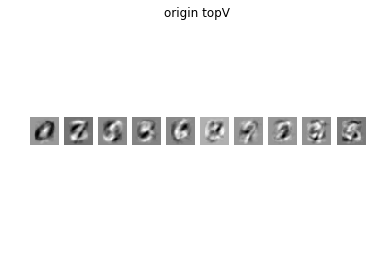

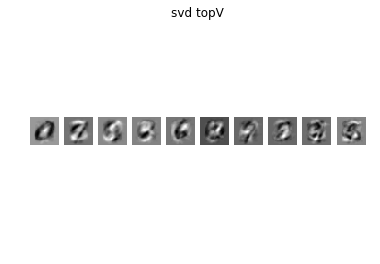

In [43]:

%matplotlib inline
import matplotlib.pyplot as plt

def show_eigen_vector(name,m, size, N = 10):
    fig = plt.figure()
    plt.title(name)
    plt.axis('off')
    if N > m.shape[1]:
        N = m.shape[1]
    for c in range(N):
        data = np.reshape(m[:,c],size)
        ax = fig.add_subplot(1, N, c+1)
        ax.axis('off')
        ax.imshow(data,cmap='gray')
        
show_eigen_vector('origin topV',topV_from_origin, sample_size)

show_eigen_vector('svd topV',topV_from_svd, sample_size)    

## PCA空间可视化

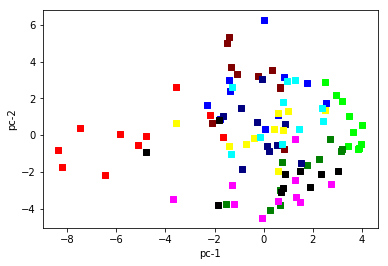

In [47]:
pcs = topV_from_svd

cValue = [(1,0,0), (0,1,0), (0,0,1), \
          (0.5, 0, 0), (0,0.5,0), (0,0,0.5),\
          (1.0,1.0,0), (1.0,0,1.0), (0,1,1),\
          (0,0,0)] 
    
Xpca = pcs.transpose().dot(Xbar)

Lx,Ly,Lc = [],[],[]
for c in range(Xpca.shape[1]):
    Lx.append(Xpca[0,c])
    Ly.append(Xpca[1,c])
    Lc.append(cValue[Y[c].astype(int)])
fig = plt.figure()
plt.xlabel('pc-1')
plt.ylabel('pc-2')
ax = fig.add_subplot(111)
ax.scatter(Lx,Ly,c = Lc, marker='s')
plt.show()


## PCA重建

* 去中心化
* 投影到PCA空间，获得pca系数
* 用pca系数乘以对应的特征向量，结果向量取和


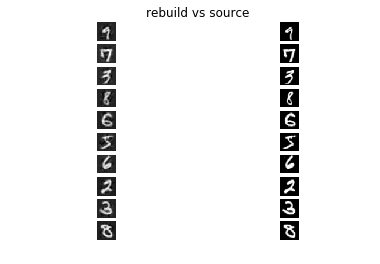

In [51]:
pcs = topV_from_svd

    
Xpca = pcs.transpose().dot(Xbar)
Xnew = pcs.dot(Xpca) + Xmean


import random
idxs = [k for k in range(X.shape[1])]
random.shuffle(idxs)


num = 10
fig = plt.figure()
plt.title('rebuild vs source')
plt.axis('off')
for n in range(num):
    c = idxs[n]
    img = np.reshape(Xnew[:,c],sample_size)
    ax = fig.add_subplot(num,2,n*2+1)
    ax.axis('off')
    ax.imshow(img,cmap='gray')
    img = np.reshape(X[:,c],sample_size)
    ab = fig.add_subplot(num,2,n*2+2)
    ab.axis('off')
    ab.imshow(img,cmap='gray')
plt.show()